<a href="https://colab.research.google.com/github/kanepickrell/memory-bridge/blob/main/memory_bridge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
import random
import time
import requests
import json
import pandas as pd
from google.colab import files

In [45]:
url = "https://raw.githubusercontent.com/kanepickrell/memory-bridge/main/MemoryExample.json"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()  # Parse JSON
    print(data)
else:
    print("Error fetching file")


{'memories': [{'memory_id': '1', 'type': 'episodic', 'date': '2023-12-25', 'context': {'location': 'Home', 'people': ['John', 'Sarah'], 'event': 'Christmas dinner'}, 'description': 'I remember having a Christmas dinner with family. We ate turkey and shared stories.', 'tags': ['family', 'holiday', 'food'], 'emotions': ['joy', 'love'], 'associated_memories': [{'memory_id': '3', 'relationship': 'related'}], 'duration': '2 hours'}, {'memory_id': '2', 'type': 'semantic', 'date': '2023-06-10', 'context': {'location': 'Classroom', 'people': ['Teacher', 'Classmates'], 'event': 'Learning about photosynthesis'}, 'description': 'I learned about photosynthesis in biology class. It was fascinating how plants convert sunlight into energy.', 'tags': ['education', 'biology', 'learning'], 'emotions': ['curiosity', 'interest'], 'associated_memories': [], 'duration': '1 hour'}, {'memory_id': '3', 'type': 'episodic', 'date': '2023-06-05', 'context': {'location': 'Park', 'people': ['John', 'Sarah'], 'event

In [46]:
df = pd.DataFrame(data)

In [47]:
df.head()

,memories
0,"{'memory_id': '1', 'type': 'episodic', 'date':..."
1,"{'memory_id': '2', 'type': 'semantic', 'date':..."
2,"{'memory_id': '3', 'type': 'episodic', 'date':..."


In [48]:
df_normalized = pd.json_normalize(df['memories'])

In [51]:
df_normalized.head()

,memory_id,type,date,description,tags,emotions,associated_memories,duration,context.location,context.people,context.event
0,1,episodic,2023-12-25,I remember having a Christmas dinner with fami...,"[family, holiday, food]","[joy, love]","[{'memory_id': '3', 'relationship': 'related'}]",2 hours,Home,"[John, Sarah]",Christmas dinner
1,2,semantic,2023-06-10,I learned about photosynthesis in biology clas...,"[education, biology, learning]","[curiosity, interest]",[],1 hour,Classroom,"[Teacher, Classmates]",Learning about photosynthesis
2,3,episodic,2023-06-05,"We went for a picnic, played frisbee, and had ...","[outdoor, exercise, social]","[happiness, relaxation]","[{'memory_id': '1', 'relationship': 'related'}]",3 hours,Park,"[John, Sarah]",Picnic in the park


In [57]:
df_normalized.columns

Index(['memory_id', 'type', 'date', 'description', 'tags', 'emotions',
       'associated_memories', 'duration', 'context.location', 'context.people',
       'context.event'],
      dtype='object')

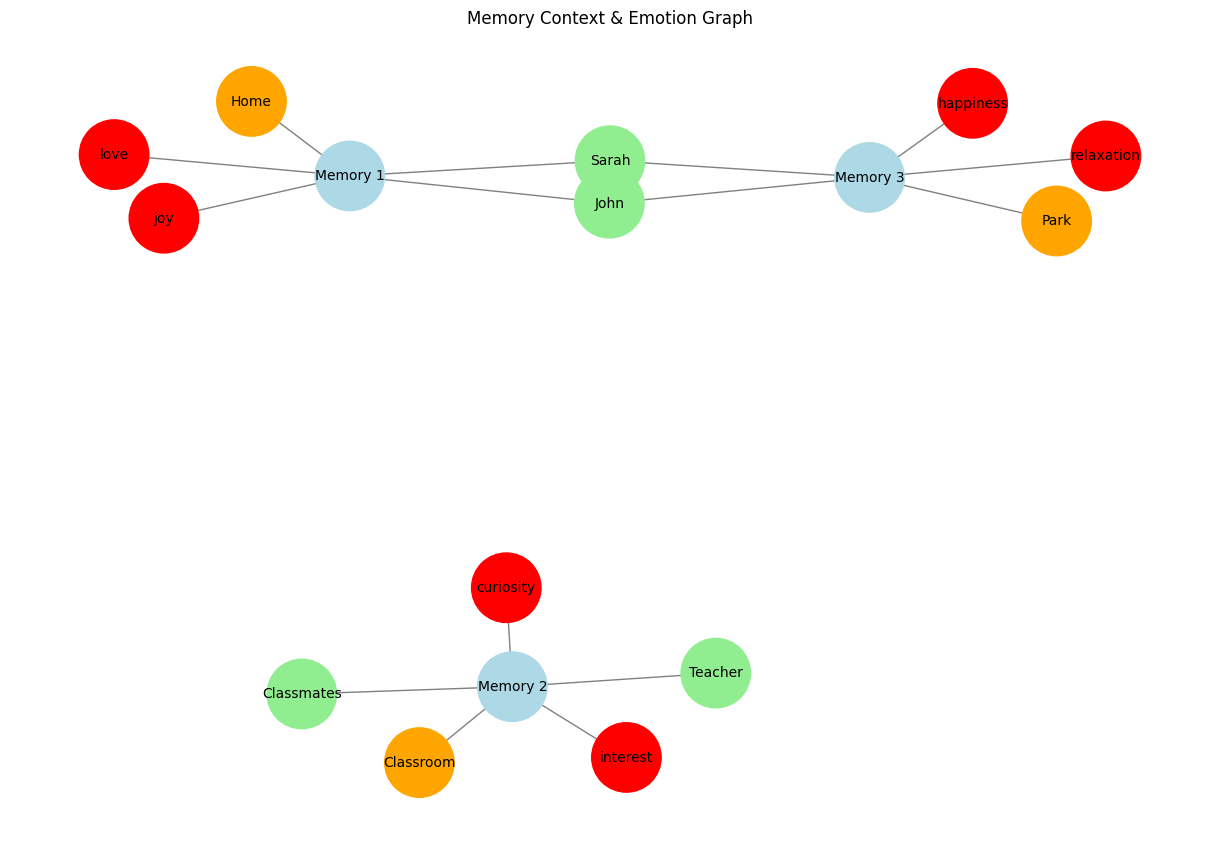

In [61]:
G2 = nx.Graph()

# adding memory nodes
for _, row in df_normalized.iterrows():
    G2.add_node(f"Memory {row['memory_id']}", label=row['description'], color="lightblue")

# adding context nodes (location, people, emotions)
for _, row in df_normalized.iterrows():
    for person in row['context.people']:
        G2.add_node(person, color="lightgreen")
        G2.add_edge(f"Memory {row['memory_id']}", person)

    G2.add_node(row['context.location'], color="orange")
    G2.add_edge(f"Memory {row['memory_id']}", row['context.location'])

    ## event node may not make final cut
    for emotion in row['emotions']:
        G2.add_node(emotion, color="red")
        G2.add_edge(f"Memory {row['memory_id']}", emotion)

# visualize
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G2)
node_colors = [G2.nodes[n].get("color", "gray") for n in G2.nodes]
nx.draw(G2, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=2500, font_size=10)

plt.title("Memory Context & Emotion Graph")
plt.show()